In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# hardcoded parameters
NUM_STUDENTS = 4602 # just undergraduates
NUM_STUDENTS_IN_RES_HALLS = 3300
NUM_STUDENTS_IN_FSILGS = NUM_STUDENTS - NUM_STUDENTS_IN_RES_HALLS
LENGTH_OF_SEMESTER = 100

NUM_INFECTED_AT_BEGINNING = 0
ATTACK_RATE_FOR_RESIDENTIAL_ENCOUNTERS = 0.329
IMMUNITY_AT_ONSET = 0.05

EXPOSURE_TIME = 2
PERCENT_ASYMPTOMATIC = 0.75
ASYMPTOMATIC_EFFECT_ON_R0 = 0.5

In [3]:
# parameter sweeps
false_positive_rates = [0.1, 0.3, 0.5, 1]
false_negative_rates = [1, 3]
pct_students_selected_for_testing_per_day = [0, 0.033, 0.066, 0.125, 0.25] # test never, every 30 days, every 15 days, every 8 days, and every 4 days

num_res_contacts_for_res_halls = [1, 2, 3]
num_res_contacts_for_fsilgs = [1, 3, 5]
r0_outside_of_residential_contacts = [0.5, 1, 2, 3]

In [4]:
# set some defaults
default_false_positive_rates = 0.1
default_false_negative_rates = 1
default_pct_students_selected_for_testing_per_day = 0.125 # test every 8 days

default_num_res_contacts_for_res_halls = 2
default_num_res_contacts_for_fsilgs = 3
default_r0_outside_of_residential_contacts = 1

In [5]:
# student populations to track
symptomatic_infected = np.zeros((LENGTH_OF_SEMESTER,), dtype=int)

asymptomatic_infected = np.zeros((LENGTH_OF_SEMESTER,), dtype=int)
asymptomatic_infected[0] = NUM_INFECTED_AT_BEGINNING

susceptible = np.zeros((LENGTH_OF_SEMESTER,), dtype=int)
susceptible[0] = NUM_STUDENTS - NUM_INFECTED_AT_BEGINNING

quarantined = np.zeros((LENGTH_OF_SEMESTER,), dtype=int)

immune = np.zeros((LENGTH_OF_SEMESTER,), dtype=int)
immune[0] = IMMUNITY_AT_ONSET * NUM_STUDENTS

In [6]:
def calc_new_infections(curr_symptomatic_infected, curr_asymptomatic_infected, 
                        curr_susceptible, curr_quarantined, curr_immune):
    return 10

In [11]:
num_to_test_every_day = default_pct_students_selected_for_testing_per_day

# run simulation over 100 days
for day_num in range(0, LENGTH_OF_SEMESTER - 1):
    ## TEST!!!
    # first test susceptible- true negative population
    tests_of_susceptible = np.int(default_pct_students_selected_for_testing_per_day * susceptible[day_num])
    pos_tests_of_susceptible = np.int(tests_of_susceptible * default_false_positive_rates)
    neg_tests_of_susceptible = tests_of_susceptible - pos_tests_of_susceptible
    
    # test all asymptomatic individuals- true positive population
    tests_of_asymptomatic = np.int(default_pct_students_selected_for_testing_per_day * asymptomatic_infected[day_num])
    pos_tests_of_asymptomatic = np.int(tests_of_asymptomatic * (1 - default_false_negative_rates))
    neg_tests_of_asymptomatic = tests_of_asymptomatic - pos_tests_of_asymptomatic
    
    # test all symptomatic individuals- true positive population
    tests_of_symptomatic = np.int(default_pct_students_selected_for_testing_per_day * symptomatic_infected[day_num])
    pos_tests_of_symptomatic = np.int(tests_of_symptomatic * (1 - default_false_negative_rates))
    neg_tests_of_symptomatic = tests_of_symptomatic - pos_tests_of_symptomatic

    # test all recovered_unknown- true negative population
    tests_of_immune = np.int(default_pct_students_selected_for_testing_per_day * immune[day_num])
    pos_tests_of_immune = np.int(tests_of_immune * default_false_positive_rates)
    neg_tests_of_immune = tests_of_immune - pos_tests_of_immune
    
    # don't test quarantined - duh
    
    
    ## INFECT!!
    # allow intermingling and new infections
    num_new_infections_today_in_susceptible_pop = calc_new_infections(symptomatic_infected[day_num], asymptomatic_infected[day_num], susceptible[day_num], quarantined[day_num], immune[day_num])

    
    ## UPDATE!!
    # we quarantine the positive tests and remove them from the population
    susceptible[day_num + 1] = susceptible[day_num] - pos_tests_of_susceptible - num_new_infections_today_in_susceptible_pop
    
    # convert some percent of infections from asymptomatic to symptomatic
    if day_num > 2:
        asymptomatic_convert_to_symptomatic = np.round((1 - PERCENT_ASYMPTOMATIC) * asymptomatic_infected[day_num - 2])
        symptomatic_infected[day_num + 1] = symptomatic_infected[day_num] - pos_tests_of_symptomatic + asymptomatic_convert_to_symptomatic
        asymptomatic_infected[day_num + 1] = asymptomatic_infected[day_num] - pos_tests_of_asymptomatic + num_new_infections_today_in_susceptible_pop - asymptomatic_convert_to_symptomatic
    else: 
        symptomatic_infected[day_num + 1] = symptomatic_infected[day_num] - pos_tests_of_symptomatic
        asymptomatic_infected[day_num + 1] = asymptomatic_infected[day_num] - pos_tests_of_asymptomatic + num_new_infections_today_in_susceptible_pop
    
    # move people out of quarantine and anyone undetected gets bumped out of asymptomatic 
    if day_num > 13:
        quarantined[day_num + 1] = np.maximum(0, pos_tests_of_susceptible + pos_tests_of_asymptomatic + pos_tests_of_symptomatic + pos_tests_of_immune + quarantined[day_num] - quarantined[day_num - 14])
                
        symptomatic_infected[day_num + 1] = symptomatic_infected[day_num] - symptomatic_infected[day_num - 14]
        asymptomatic_infected[day_num + 1] = asymptomatic_infected[day_num] - asymptomatic_infected[day_num - 14]

        immune[day_num + 1] = immune[day_num] + symptomatic_infected[day_num - 14] + asymptomatic_infected[day_num - 14] - pos_tests_of_immune

    else:  
        quarantined[day_num + 1] = np.maximum(0, pos_tests_of_susceptible + pos_tests_of_asymptomatic + pos_tests_of_symptomatic + pos_tests_of_immune + quarantined[day_num])
        immune[day_num + 1] = immune[day_num] - pos_tests_of_immune

    # and we let others continue interacting
    
    # update our populations

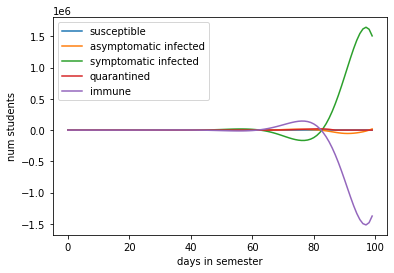

In [12]:
# plot student populations
plt.plot(susceptible, label='susceptible')
plt.plot(asymptomatic_infected, label='asymptomatic infected')
plt.plot(symptomatic_infected, label='symptomatic infected')
plt.plot(quarantined, label='quarantined')
plt.plot(immune, label='immune')

plt.legend()
plt.xlabel('days in semester')
plt.ylabel('num students')
plt.show()

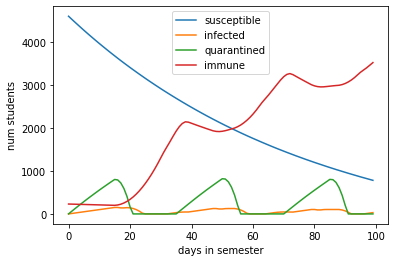

In [9]:
# plot student populations
plt.plot(susceptible, label='susceptible')
plt.plot(asymptomatic_infected + symptomatic_infected, label='infected')
plt.plot(quarantined, label='quarantined')
plt.plot(immune, label='immune')

plt.legend()
plt.xlabel('days in semester')
plt.ylabel('num students')
plt.show()